# 0. Google Colab Setups

In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls

bloom-finetuned-icliniq    dataset			    MedQuAD_BLOOM_finetuning.ipynb
bloom-finetuned-medQuad    eda_train_test_generation.ipynb  MedQuAD_data_preprocessing.ipynb
bloom-finetuned-medQuad-2  iCliniq_BLOOM_finetuning.ipynb   medQuAD_gen_ans.csv


In [ ]:
os.chdir('./drive/MyDrive/NLP MedLM project')

FileNotFoundError: [Errno 2] No such file or directory: './drive/MyDrive/NLP MedLM project'

In [ ]:
!pip install transformers

In [ ]:
!pip install datasets

In [ ]:
!pip install accelerate -U

In [ ]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


In [ ]:
!pip install rouge_score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24933 sha256=08fb6abd3088ec2d2f699ee79b5c8a5d01b0c73cfb4775d3d197b8652ae61251
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge_score


# 1. Preprocessing MedQuAD
+ Question and Anaswers needs to be combined to QA pairs for fine-tuning.
+ Only Question is needed for the testing data.
+ For training set data: Add [question] beofore each question text, and add[answer] before each answer text. For test set data: Add [question] before each question text and add [answer] to the end of the question.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import torch
from transformers import BloomTokenizerFast, BloomForCausalLM, pipeline
from datasets import DatasetDict, Dataset
from transformers import Trainer, TrainingArguments
import evaluate

from tqdm import tqdm
import ast

In [ ]:
# load MedQuAD train and test dataset
train_df = pd.read_csv('./dataset/MedQuAD_train.csv')
test_df = pd.read_csv('./dataset/MedQuAD_test.csv')

In [ ]:
# add special tokens
# adding prompting tokens before each question and answer
def prepend_q(row):
  return '[question] ' + str(row)

def prepend_a(row):
  return '\n [answer] ' + str(row)

def prepend_qa(row):
  return '[question] ' + str(row) + '\n [answer]'

train_df['Question'] = train_df['Question'].apply(prepend_q)
train_df['Answer_cut'] = train_df['Answer_cut'].apply(prepend_a)
#combine question and answer
train_df['QA'] = train_df['Question'].str.cat(train_df['Answer_cut'], sep = '')

test_df['Question'] = test_df['Question'].apply(prepend_qa)

In [ ]:
# check data
train_df.head(1)

,Question,Answer,Answer_cut,QA
0,[question] What are the treatments for Lupus ?,How might lupus be treated? For information on...,\n [answer] How might lupus be treated? For in...,[question] What are the treatments for Lupus ?...


In [ ]:
test_df.head(1)

,Question,Answer,Answer_cut
0,[question] What are the complications of Pyelo...,Most people with pyelonephritis do not have co...,Most people with pyelonephritis do not have co...


In [ ]:
# split part of the data for evaluation
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=123)

In [ ]:
# form dataset with hf datasets
train = {
    "text" : train_df['QA']
}
test = {
    "text": val_df['QA']
}

train_dataset = Dataset.from_dict(train)
test_dataset = Dataset.from_dict(test)

datasets = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

# 2. Tokenization
+ Use tokenizer designed for BLOOM

In [ ]:
MODEL_TYPE = "bigscience/bloom-560m"
MAX_LENGTH = 300

tokenizer = BloomTokenizerFast.from_pretrained(MODEL_TYPE)
model = BloomForCausalLM.from_pretrained(MODEL_TYPE)

device = "cuda:0" if torch.cuda.is_available() else "cpu"
model = model.to(device)
print(device)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/222 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/693 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

cuda:0


In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=MAX_LENGTH)

In [ ]:
# need to delete the original text column
tokenized_dataset = datasets.map(tokenize_function, batched=True, num_proc=8, remove_columns=["text"])

Map (num_proc=8):   0%|          | 0/10491 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2623 [00:00<?, ? examples/s]

In [ ]:
tokenized_dataset

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 10491
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 2623
    })
})

In [ ]:
block_size = MAX_LENGTH
def group_texts(examples):
  # Concatenate all texts.
  # examples = {k: sum(examples[k], []) for k in examples.keys()}
  #   total_length = len(concatenated_examples[list(examples.keys())[0]])
  #   # We drop the small remainder, we could add padding if the model supported it instead of this drop, you can
  #       # customize this part to your needs.
  #   total_length = (total_length // block_size) * block_size
  #   # Split by chunks of max_len.
  #   result = {
	# k: [t[i : i + block_size] for i in range(0, total_length, block_size)]
  #       for k, t in concatenated_examples.items()
  #   }
  examples["labels"] = examples["input_ids"].copy()
  return examples

In [ ]:
lm_datasets = tokenized_dataset.map(
    group_texts,
    batched=True,
    batch_size=100,
    num_proc=8,
)

Map (num_proc=8):   0%|          | 0/10491 [00:00<?, ? examples/s]

Map (num_proc=8):   0%|          | 0/2623 [00:00<?, ? examples/s]

In [ ]:
lm_datasets['train'][0]

# 3. Fine-Tuning
+ From research, we learned that the learning rate during finetuning partly depends on the size of the dataset, when the dataset is small, it is better to use smaller learning rate.

In [ ]:
training_args = TrainingArguments(
    f"bloom-finetuned-medQuad",
    per_device_train_batch_size=2,
    gradient_checkpointing=True,
    gradient_accumulation_steps=4,
    optim="adafactor",
    logging_steps=100,
    save_strategy='epoch',
    weight_decay=0.1,
    learning_rate=5e-6,
    evaluation_strategy='steps',
    eval_steps=400,
    tf32=False,
    per_device_eval_batch_size=2,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differe

Step,Training Loss,Validation Loss
400,1.077400,1.107705
800,0.987700,1.043501
1200,1.007100,1.004751
1600,0.926200,0.989862
2000,0.952500,0.972243
2400,0.886800,0.959056
2800,0.809300,0.958980
3200,0.850600,0.954186
3600,0.814500,0.949252


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=3933, training_loss=0.9416258543040229, metrics={'train_runtime': 16764.156, 'train_samples_per_second': 1.877, 'train_steps_per_second': 0.235, 'total_flos': 1.71204956209152e+16, 'train_loss': 0.9416258543040229, 'epoch': 3.0})

In [ ]:
training_args = TrainingArguments(
    f"bloom-finetuned-medQuad",
    num_train_epochs= 2, # 3 epoch is not practical
    per_device_train_batch_size= 2,
    gradient_checkpointing= True,
    gradient_accumulation_steps= 5,
    optim= "adafactor",
    logging_steps= 50,
    save_strategy= 'epoch',
    weight_decay= 0.1,
    learning_rate= 5e-6,
    evaluation_strategy= 'steps',
    eval_steps= 200,
    per_device_eval_batch_size= 2,
    warmup_ratio = 0.01 # epoch * 1%
)

trainer = Trainer(
    model= model,
    args= training_args,
    train_dataset= lm_datasets["train"],
    eval_dataset= lm_datasets["test"],
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss,Validation Loss


Step,Training Loss,Validation Loss
200,0.986700,1.056094
400,1.015300,1.036795
600,0.935400,1.016985
800,0.927000,0.998986
1000,1.008600,0.982334
1200,0.821400,0.980296


Checkpoint destination directory bloom-finetuned-medQuad/checkpoint-1049 already exists and is non-empty. Saving will proceed but saved results may be invalid.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


In [ ]:
trainer.state.log_history

In [ ]:
training_args = TrainingArguments(
    f"bloom-finetuned-medQuad-2",
    num_train_epochs= 2, # 3 epoch is not practical
    per_device_train_batch_size= 2,
    gradient_checkpointing= True,
    gradient_accumulation_steps= 5,
    optim= "adafactor",
    logging_steps= 50,
    save_strategy= 'epoch',
    weight_decay= 0.1,
    learning_rate= 5e-6,
    evaluation_strategy= 'steps',
    eval_steps= 200,
    per_device_eval_batch_size= 2,
    warmup_ratio = 0.02 # epoch * 1%
)

trainer = Trainer(
    model= model,
    args= training_args,
    train_dataset= lm_datasets["train"],
    eval_dataset= lm_datasets["test"],
)

trainer.train()

Step,Training Loss,Validation Loss
200,1.185400,1.167319
400,1.146800,1.100529
600,1.027700,1.059953
800,0.988700,1.034885
1000,1.046400,1.016012
1200,0.894600,1.005907
1400,0.851900,0.996971
1600,0.944700,0.989211
1800,0.919500,0.983729
2000,0.871200,0.980688


/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


TrainOutput(global_step=2098, training_loss=1.1773014468619434, metrics={'train_runtime': 12148.7225, 'train_samples_per_second': 1.727, 'train_steps_per_second': 0.173, 'total_flos': 1.14160217923584e+16, 'train_loss': 1.1773014468619434, 'epoch': 2.0})

In [ ]:
train_log = pd.DataFrame(trainer.state.log_history)
train_log.to_csv("./bloom-finetuned-medQuad-2/train_log.csv", index = False)

<Axes: >

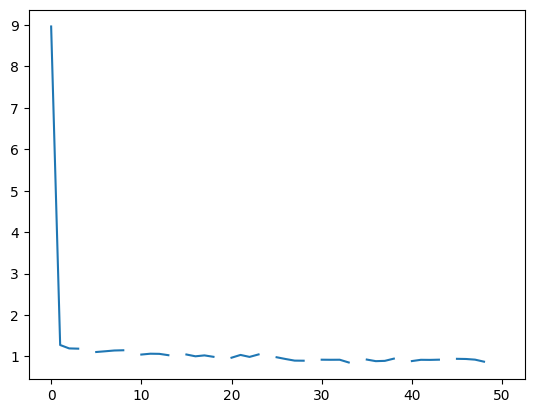

In [ ]:
# plot the training and validation loss
train_log['loss'].plot()

# 4. Inference
+ Use the finetuned model to perform inference on the test set

In [ ]:
tokenizer = BloomTokenizerFast.from_pretrained(MODEL_TYPE)
model = BloomForCausalLM.from_pretrained("./bloom-finetuned-medQuad-2/checkpoint-2098")
model.eval()

BloomForCausalLM(
  (transformer): BloomModel(
    (word_embeddings): Embedding(250880, 1024)
    (word_embeddings_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (h): ModuleList(
      (0-23): 24 x BloomBlock(
        (input_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (self_attention): BloomAttention(
          (query_key_value): Linear(in_features=1024, out_features=3072, bias=True)
          (dense): Linear(in_features=1024, out_features=1024, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (post_attention_layernorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (mlp): BloomMLP(
          (dense_h_to_4h): Linear(in_features=1024, out_features=4096, bias=True)
          (gelu_impl): BloomGelu()
          (dense_4h_to_h): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
    )
    (ln_f): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  )
  (

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
generator = pipeline('text-generation', model=model.to(device), device = 0, tokenizer=tokenizer, do_sample=False)

In [ ]:
# test questions as list
test_data = test_df['Question'].tolist()

In [ ]:
# monitor the process
print(len(test_data))
chunk_size = len(test_data) // 100

# Divide the list into sublists
sublists = [test_data[i:i+chunk_size] for i in range(0, len(test_data), chunk_size)]
print(len(sublists))

3279
103


In [ ]:
# inference on all data
# test different batchsize to find the best suitable one
gen_ans_lists = []
for sub_test_data in tqdm(sublists):
  with torch.no_grad():
    gen_ans = generator(sub_test_data, max_length=300, batch_size=32 )
    gen_ans_lists.append(gen_ans)

100%|██████████| 103/103 [16:42<00:00,  9.73s/it]


In [ ]:
# inference on all test data
# this is inference without parallelism -> use over 6 hours to finish all inferences

# gen_ans_list = []
# for q in tqdm(test_df['Question'].tolist()):
#   with torch.no_grad():
#     gen_ans = (generator(q, max_length = MAX_LENGTH))

#   # only keep the text after prompt '\n [answer]'
#   prompt = "\n [answer]"
#   prompt_index = gen_ans[0]['generated_text'].find(prompt)
#   if prompt_index != -1:
#     extracted_ans = gen_ans[0]['generated_text'][prompt_index + len(prompt): ]
#   else: # handle edge case
#     extracted_ans = gen_ans[0]['generated_text']
#   gen_ans_list.append(extracted_ans)

In [ ]:
# store the temporary generated answers
len(gen_ans_lists)
gen_ans_df = pd.DataFrame(gen_ans_lists)
gen_ans_df.to_csv("medQuAD_gen_ans.csv", index = False)

# 6. Evaluation
+ Use SacreBleu score and

In [ ]:
# load the generated answers
gen_ans_df = pd.read_csv("medQuAD_gen_ans.csv")
gen_ans_df.head(2)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,[{'generated_text': '[question] What are the c...,"[{'generated_text': ""[question] What is (are) ...",[{'generated_text': '[question] What is (are) ...,[{'generated_text': '[question] What are the s...,[{'generated_text': '[question] How many peopl...,[{'generated_text': '[question] What are the s...,[{'generated_text': '[question] What is (are) ...,[{'generated_text': '[question] Do you have in...,[{'generated_text': '[question] What is (are) ...,[{'generated_text': '[question] How many peopl...,...,[{'generated_text': '[question] What to do for...,[{'generated_text': '[question] How to diagnos...,[{'generated_text': '[question] Is desmosterol...,[{'generated_text': '[question] What is (are) ...,[{'generated_text': '[question] What is (are) ...,[{'generated_text': '[question] What is (are) ...,[{'generated_text': '[question] What are the t...,[{'generated_text': '[question] What is (are) ...,[{'generated_text': '[question] What are the t...,[{'generated_text': '[question] What is (are) ...
1,[{'generated_text': '[question] What are the s...,"[{'generated_text': ""[question] What causes Ac...",[{'generated_text': '[question] What are the g...,[{'generated_text': '[question] What are the t...,[{'generated_text': '[question] What to do for...,[{'generated_text': '[question] Who is at risk...,[{'generated_text': '[question] What are the s...,[{'generated_text': '[question] What causes In...,[{'generated_text': '[question] What is (are) ...,[{'generated_text': '[question] What are the s...,...,[{'generated_text': '[question] What are the t...,[{'generated_text': '[question] What are the t...,[{'generated_text': '[question] what research ...,[{'generated_text': '[question] What are the t...,[{'generated_text': '[question] Do you have in...,"[{'generated_text': ""[question] What is (are) ...",[{'generated_text': '[question] How many peopl...,[{'generated_text': '[question] What are the s...,[{'generated_text': '[question] What are the s...,[{'generated_text': '[question] How many peopl...


In [ ]:
# extract the generated answers with sequence
gen_ans_list = []

for index, row in gen_ans_df.iterrows():
    for col in gen_ans_df.columns:
      try:
        ans = ast.literal_eval(row[col])[0]['generated_text']
        # only keep the answer part
        prompt = "\n [answer]"
        prompt_index = ans.find(prompt)
        if prompt_index != -1:
          extracted_ans = ans[prompt_index + len(prompt): ]
        else: # handle edge case
          extracted_ans = ans
      except:
        continue
      gen_ans_list.append(extracted_ans)


In [ ]:
# check the number of datapoints
print(len(test_df))
print(len(gen_ans_list))

# check a random sample's question and answer
print("question: ", test_df['Question'].iloc[2048])
print("generated_answer: ", gen_ans_list[2048])
print("reference_answer: ", test_df['Answer'].iloc[2048])

3279
3279
question:  [question] What are the symptoms of Ulcerative Colitis ?
 [answer]
generated_answer:   The most common symptom of ulcerative colitis is abdominal pain. The pain may be intense or it may be mild. The pain may be caused by inflammation of the colon or rectum. The pain may also be caused by a change in the bowel habits. The pain may be caused by inflammation of the colon or rectum. The pain may be caused by a change in the bowel habits. The pain may be caused by inflammation of the colon or rectum. The pain may be caused by a change in the bowel habits. The pain may be caused by inflammation of the colon or rectum. The pain may be caused by a change in the bowel habits. The pain may be caused by inflammation of the colon or rectum. The pain may be caused by a change in the bowel habits. The pain may be caused by inflammation of the colon or rectum. The pain may be caused by a change in the bowel habits. The pain may be caused by inflammation of the colon or rectum. Th

In [ ]:
"""
calculate SACREBLEU score
This part of the code is in reference to the official document provided by huggingface
https://huggingface.co/spaces/evaluate-metric/sacrebleu
"""
sacrebleu = evaluate.load("sacrebleu")

In [ ]:
# construct reference list
references = [[ref_ans] for ref_ans in test_df['Answer']]
predictions = gen_ans_list
sacrebleu_results = sacrebleu.compute(predictions=predictions, references=references)

In [ ]:
print(sacrebleu_results)

{'score': 14.108518811297078, 'counts': [215685, 106234, 79773, 70085], 'totals': [758994, 755715, 752436, 749157], 'precisions': [28.417220689491618, 14.057415824748748, 10.601964818270257, 9.355181891112277], 'bp': 1.0, 'sys_len': 758994, 'ref_len': 735820}


In [ ]:
"""
calculate the ROUGE score
This part of the code is in reference to the official document provided by huggingface
https://huggingface.co/spaces/evaluate-metric/rouge
"""
rouge = evaluate.load("rouge")

In [ ]:
rouge_results = rouge.compute(predictions=predictions, references=references)

In [ ]:
print(rouge_results)

{'rouge1': 0.268371749105772, 'rouge2': 0.1388054020844695, 'rougeL': 0.2192314275772845, 'rougeLsum': 0.21919681767718424}
